<center>
    <h1 style="width: 90%">Understanding Relationships Between Professor Info and Course Enrollment Rates in the Computer Science Department at the University of Maryland, College Park</h1>
    <h2 style="width: 90%">By Wesley Smith, Franco Edah, and Ohsun Kwon</h2>
</center>

When given the ability of choice, people nearly always seek out the best possible selection to ensure their own success. As university students, even within our course selections, we seek to make the best decisions possible. Students commonly speak about checking grade data on [PlanetTerp](https://planetterp.com) and looking at professor reviews. In this project, we are looking to better understand the relationship between average GPA and average rating compared to course enrollment rates. Our analysis is going to concentrate on the Department of Computer Science at the University of Maryland, College Park because it is a department that we can best understand ourselves and our peers.

# Obtaining our Data

Before we are able to begin our analysis, we first need to retrieve the publicly available data about professors and courses within the Computer Science Department. Using APIs developed by our peer students at the University hosted on [umd.io](https://umd.io) and [PlanetTerp](https://planetterp.com), we are able to secure the necessary data to conduct our analyses.

Fetching large amounts of data from the umd.io and PlanetTerp APIs as we were working on this project turned out to be costly both in terms of the amount of time we were waiting for data to process, and costly for the APIs themselves, with us sometimes being rate-limited when fixing small mistakes. For reference, being rate-limited is when too many requests are sent to a public API, and the API limits requests from your address in an effort to conserve resources for others. 

In order to solve the costliness of fetching and re-fetching the data from these publicly available APIs, we instead fetch all of the data about CMSC (Dept. of Computer Science) courses at UMCP at the beginning of our project, store them in an SQLite database, and use this database to do necessary queries throughout our data analysis.

We chose the SQLite database over other initial solutions like MongoDB due to SQLite having native support in the Pandas library, along with the fact that storing our data in a table-like fashion made the most sense considering Pandas needs to represent it as a table as well. If we were to use MongoDB for example, we would need to query the database and then flatten our data to be placed into a Pandas dataframe for analysis anyways. By representing the data as a table from the beginning, we remove this rather redundant step when importing our data. Furthermore, keeping the data local in our own repository was also another plus, as needing to connect to a remote service for hosting our data could involve extra costs and complexity in our analysis.

Below is the code that scrapes the umd.io and PlanetTerp APIs and stores the necessary data that we recieve in our local SQLite database.

## Connect to the Database

Below is a helper function to help us connect to the database throughout our project.

In [1]:
import sqlite3
def open_conn():
    return sqlite3.connect("project.db")

with open_conn() as conn:
    print(conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())

[('courses',), ('instructor_reviews',), ('course_grades',), ('course_sections',), ('course_section_instructors',)]


## Fetch and Write Basic Course Info

First, we need to get a list of all of the courses that are available within the `umd.io` API for us to fetch. However, we cannot get all of our data in one API request because:
1. The API returns results in a paginated form, and we can only request up to 100 entries on each page. So, if there are more courses than 100 for a single set of request parameters, we need to keep fetching the next page until there are no more results to return.
2. The API is supposed to support being able to request all courses less than or equal to (`leq`) than a semester, but the API seems to be broken and does not accept strings longer than six characters. To provide the `leq` option, we would need to provide `202008|leq` for the semester parameter, which is 10 characters long. To work around this issue, we start at the current year (`2022`) and iteratively make a call for both the spring `01` semester and `08` fall semesters for each year, decrementing the year each iteration. 

In [2]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
import requests

def get_courses(page, semester):
    params = {"dept_id": "CMSC", "per_page": 100, "page": page, "semester": semester}
    return requests.get("https://api.umd.io/v1/courses", params=params).json()

def fetch_for_semester(semester):
    result = []
    page = 1
    while True:
        response = get_courses(page, semester)
        if "error_code" in response:
            if response["message"] == "We don't have data for this semester!":
                # theres no data to fetch! stop now
                break
            raise Exception(f"unknown error response: {response}")
                
        if len(response) == 0:
            # if we got no result, then we reached the last page
            break
            
        result += response
        page += 1
    return result

def fetch_for_year(year):
    result = []
    for semester_id in ["01", "08"]:
        result += fetch_for_semester(f"{year}{semester_id}")
    return result

courses = []
for year in range(2017, 2023):
    courses += fetch_for_year(year)

len_courses = len(courses)
print(f"amount of courses fetched: {len_courses}")

amount of courses fetched: 880


We recieved 880 courses that were registered in the umd.io database within the Computer Science department. From here, we will write this information to our SQLite database to use for later.

In [3]:
# helper function for parsing a semester in the format string "{year}{01|08}", where 01 is spring and 08 is fall
def parse_semester(semester_raw):
    semester_year = semester_raw[0:4]
    semester_id = int(semester_raw[4:])
    semester_enum = "SPRING" if semester_id == 1 else "FALL" if semester_id == 8 else None
    return semester_year, semester_enum

In [4]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS courses") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS courses (
        id CHAR(7) NOT NULL,
        dept CHAR(4) NOT NULL,
        number VARCHAR(4) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        credits INT(1) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (id, year, semester)
    )
    """)

    for course in courses:
        course_id = course["course_id"]
        dept = course["dept_id"]
        number = course_id[len(dept):]
        # ignore classes higher than the 400 level
        if int(number[0]) > 4:
            continue 

        year, semester = parse_semester(course["semester"])
        credits = int(course["credits"])
        cur.execute(
            "INSERT OR IGNORE INTO courses (id, dept, number, year, semester, credits) VALUES (?, ?, ?, ?, ?, ?)",
            (course_id, dept, number, year, semester, credits)
        )

    print(list(cur.execute("SELECT * FROM courses LIMIT 5")))

[('CMSC100', 'CMSC', '100', 2017, 'FALL', 1), ('CMSC106', 'CMSC', '106', 2017, 'FALL', 4), ('CMSC122', 'CMSC', '122', 2017, 'FALL', 3), ('CMSC131', 'CMSC', '131', 2017, 'FALL', 4), ('CMSC131A', 'CMSC', '131A', 2017, 'FALL', 4)]


Now, the courses have been inserted. While we were inserting, when we saw duplicate courses, that means we have already registered it into our database, so we simply ignore it. That is why our query contains `INSERT OR IGNORE`. Furthermore, while we are writing, we are also parsing umd.io's semester field into the year and `FALL`/`SPRING` enum values. The field is formatted with `<year><01|08>`, where `01` is `SPRING` and 08 is `FALL`.

## Fetching and Writing Course Section Info

Now that we have our course data, we need to get more fine-grained data about who teaches the course and the seat data for each of their sections, permitting us to consider course registration rates in our data analysis. 

In [33]:
# YOU SHOULD NOT RUN THIS CODE BLOCK UNLESS YOU ARE WANTING TO LOAD NEW DATA
import math

SECTIONS_PER_PAGE = 100

def get_sections(course_id, semester, page):
    params = params={
        "course_id": course_id, 
        "semester": semester,
        "page": page, 
        "per_page": SECTIONS_PER_PAGE
    }
    return requests.get("https://api.umd.io/v1/courses/sections", params=params).json()

def get_all_sections(course_id, semester, num_sections):
    sections = []
    num_pages = int(math.ceil(num_sections / SECTIONS_PER_PAGE))
    for page_idx in range(num_pages):
        result = get_sections(course_id, semester, page_idx + 1)
        sections += result
    return sections

def insert_section(cur, section):
    course_id = section["course"]
    year, semester = parse_semester(str(section["semester"]))
    number = section["number"]
    seats_open = int(section["open_seats"])
    seats = int(section["seats"])
    seats_taken = seats - seats_open
    waitlist = int(section["waitlist"])
    instructors = section["instructors"]
    # uncomment for debug
    # print(f"processing section {number} of {course_id} for year {year}, semester {semester} with instructors {instructors}")
    cur.execute(
        """
        INSERT INTO course_sections (course, year, semester, number, seats_open, seats_taken, waitlist_size)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """,
        (course_id, year, semester, number, seats_open, seats_taken, waitlist)
    )
    
    for instructor_name in section["instructors"]:
        cur.execute(
            """
            INSERT INTO course_section_instructors (course, year, semester, number, name)
            VALUES (?, ?, ?, ?, ?)
            """,
            (course_id, year, semester, number, instructor_name)
        )

with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS course_sections") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_sections (
        course CHAR(7) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        number VARCHAR(4) NOT NULL,
        seats_open INT(4) NOT NULL,
        seats_taken INT(4) NOT NULL,
        waitlist_size INT(4) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, year, semester, number),
        FOREIGN KEY (course, year, semester) REFERENCES courses(id, year, semester)
    )
    """)
    cur.execute("DROP TABLE IF EXISTS course_section_instructors") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_section_instructors (
        course CHAR(7) NOT NULL,
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        number VARCHAR(4) NOT NULL,
        name VARCHAR(100) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, year, semester, number, name),
        FOREIGN KEY (course, year, semester, number) REFERENCES course_sections(id, year, semester, number)
    ) 
    """)

    for course in courses:
        course_id = course["course_id"]
        semester = course["semester"]
        num_sections = len(course["sections"])
        sections = get_all_sections(course_id, semester, num_sections)
        for section in sections:
            insert_section(cur, section)

    print(list(cur.execute("SELECT * FROM course_sections LIMIT 5")))
    print(list(cur.execute("SELECT * FROM course_section_instructors LIMIT 5")))

[('CMSC122', 2019, 'SPRING', '0101', 3, 82, 0), ('CMSC122', 2019, 'SPRING', '0201', 47, 123, 0), ('CMSC131', 2019, 'SPRING', '0101', 6, 26, 0), ('CMSC131', 2019, 'SPRING', '0102', 2, 36, 0), ('CMSC131', 2019, 'SPRING', '0103', 3, 29, 0)]
[('CMSC122', 2019, 'SPRING', '0101', 'Brian Brubach'), ('CMSC122', 2019, 'SPRING', '0201', 'Pedram Sadeghian'), ('CMSC131', 2019, 'SPRING', '0101', 'Ilchul Yoon'), ('CMSC131', 2019, 'SPRING', '0102', 'Ilchul Yoon'), ('CMSC131', 2019, 'SPRING', '0103', 'Ilchul Yoon')]


## Fetching Professor Ratings

In our analysis, we also seek to consider how course ratings affect enrollment rates. Using the PlanetTerp API, we are able to fetch the course ratings for given professors.

In [6]:
def get_prof_avgRating(prof):
    r = requests.get('https://api.planetterp.com/v1/professor', params={'name': prof})
    r = r.json()

    if "average_rating" in r:
        return r['average_rating']
    else:
        return None

In [7]:
with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS instructor_reviews") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS instructor_reviews (
        course CHAR(7) NOT NULL,
        instructor_name VARCHAR(100) NOT NULL,
        rating INT(1) NOT NULL,
        avg_class_gpa DOUBLE(2,2),
        CONSTRAINT primary_key PRIMARY KEY (course, instructor_name),
        FOREIGN KEY (course) REFERENCES courses(id)
    )
    """)

    unique_course_ids = set(map(lambda x: x["course_id"], courses))
    for course_id in unique_course_ids:
        response = requests.get("https://api.planetterp.com/v1/course", params={"name": course_id}).json()
        if "error" in response:
            print(f"failed resp {response}")
            continue

        avg_class_gpa = response["average_gpa"]


        for professor in response["professors"]:
            rating = get_prof_avgRating(professor)

            cur.execute(
                "INSERT OR IGNORE INTO instructor_reviews (course, instructor_name, rating, avg_class_gpa) VALUES (?, ?, ?, ?)",
                (course_id, professor, rating, avg_class_gpa)
            )

    print(list(cur.execute("SELECT * FROM instructor_reviews LIMIT 5")))

failed resp {'error': 'course not found'}
failed resp {'error': 'course not found'}
failed resp {'error': 'course not found'}
[('CMSC498K', 'Alan Sussman', 3.25, None), ('CMSC421', 'Hal Daume', 3, 3.01543), ('CMSC421', 'Dana Nau', 2.2727, 3.01543), ('CMSC421', 'Donald Perlis', 3.3158, 3.01543), ('CMSC421', 'James Reggia', 4.0909, 3.01543)]


## Fetching Grade Data

We also want to consider how the average GPA for each class and more specifically for the sections that a particular teaches would affect which sections students would be most likely to register for. We thus need to get the grades data from the PlanetTerp API and aggregate them per class, section, and professors. 

In [8]:
GRADE_POINTS = {
    "A+": 4.0, "A": 4.0, "A-": 3.7, 
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0, "D-": 0.5,
    "F": 0.0
}

def db_write_course_grades(conn, course_id, plt_terp_grades):
    cur = conn.cursor()
    for entry in plt_terp_grades:
        num_grade_w = int(entry["W"])
        prof_name = entry["professor"]
        semester_raw = entry["semester"]
        year, semester = parse_semester(semester_raw)
            
        # if we can't identify fall or spring semester,
        # then the course isnt relevant to our data
        if semester == None:
            continue
            
        # loop over keys and values and check if key is a grade
        # name. if so, add it to our grade point sum and total
        # amount of grades.
        grade_point_sum = 0
        total_grades = 0
        for key, value in entry.items():
            if key not in GRADE_POINTS:
                continue
            
            grade_points = GRADE_POINTS[key]
            amt = int(value)
            total_grades += amt
            grade_point_sum += amt * grade_points
        
        if total_grades == 0:
            gpa = None
        else:
            gpa = grade_point_sum / total_grades

        cur.execute(
            """
            INSERT INTO course_grades (course, instructor_name, year, semester, gpa, num_drops)
            VALUES (?, ?, ?, ?, ?, ?)
            ON CONFLICT(course, instructor_name, year, semester) 
                DO UPDATE SET gpa = (gpa + excluded.gpa) / 2, num_drops = num_drops + excluded.num_drops
            """,
            (course_id, prof_name, year, semester, gpa, num_grade_w)
        )

with open_conn() as conn:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS course_grades") # uncomment if you'd like to start over
    cur.execute("""
    CREATE TABLE IF NOT EXISTS course_grades (
        course CHAR(7) NOT NULL,
        instructor_name VARCHAR(100),
        year INT(4) NOT NULL,
        semester VARCHAR(10) NOT NULL,
        gpa DOUBLE(2,2),
        num_drops INT(5) NOT NULL,
        CONSTRAINT primary_key PRIMARY KEY (course, instructor_name, year, semester),
        FOREIGN KEY (course) REFERENCES courses(id)
    )
    """)

    unique_course_ids = set(map(lambda x: x["course_id"], courses))
    for course_id in unique_course_ids:
        response = requests.get("https://api.planetterp.com/v1/grades", params={"course": course_id}).json()
        if "error" in response:
            error_msg = response["error"]
            print(f"course {course_id} got error {error_msg}")
            continue

        db_write_course_grades(conn, course_id, response)

    print(list(cur.execute("SELECT * FROM course_grades LIMIT 5")))

course CMSC848C got error course not found
course CMSC388X got error course not found
course CMSC838C got error course not found
[('CMSC421', 'James Reggia', 2021, 'FALL', 3.4806451612903224, 3), ('CMSC421', 'Marine Carpuat', 2021, 'FALL', 3.333333333333334, 8), ('CMSC421', 'Pratap Tokekar', 2021, 'SPRING', 3.566666666666666, 2), ('CMSC421', 'James Reggia', 2021, 'SPRING', 3.573846153846154, 1), ('CMSC421', 'William Regli', 2020, 'FALL', 3.0845588235294112, 12)]


# Basic Analysis

We collect and merge the various tables we  created so far to have a single source of information. Doin so facilitates the various queries that we will need to do to conduct a throughout analysis of the phenomena we are interested in. We use the course ID, year, semester and instructor name to join these tables into a master pandas dataframe name df

In [9]:
import pandas as pd

query = """
SELECT
    courses.id AS course_id,
    courses.year,
    courses.semester,
    courses.credits,
    course_grades.instructor_name,
    instructor_reviews.avg_class_gpa AS avg_course_gpa,
    AVG(instructor_reviews.rating) AS avg_prof_rating,
    AVG(course_grades.gpa) AS avg_prof_gpa,
    SUM(course_grades.num_drops) AS total_num_drops
FROM courses
LEFT JOIN course_grades
    ON course_grades.course = courses.id
    AND course_grades.year = courses.year
    AND course_grades.semester = courses.semester
LEFT JOIN instructor_reviews
    ON instructor_reviews.course = courses.id
    AND instructor_reviews.instructor_name = course_grades.instructor_name
/*WHERE course_grades.course = 'CMSC132'*/
GROUP BY
    course_grades.course,
    course_grades.instructor_name,
    course_grades.year,
    course_grades.semester
"""
with open_conn() as conn:
    df = pd.read_sql(sql=query, con=conn, index_col="course_id")
    df = df.reset_index(0)
    display(df)

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops
0,CMSC298A,2017,FALL,1,None,NaN,NaN,NaN,NaN
1,CMSC100,2017,FALL,1,Alyssa Neuner,NaN,NaN,3.758824,1.0
2,CMSC100,2018,FALL,1,Alyssa Neuner,NaN,NaN,3.900000,0.0
3,CMSC100,2017,FALL,1,Amy Vaillancourt,NaN,NaN,3.960000,2.0
4,CMSC100,2018,FALL,1,Amy Vaillancourt,NaN,NaN,3.937500,1.0
...,...,...,...,...,...,...,...,...,...
502,CMSC498X,2019,FALL,3,Marc Lichtman,NaN,NaN,3.577419,0.0
503,CMSC499A,2019,FALL,1,None,NaN,NaN,4.000000,0.0
504,CMSC499A,2019,SPRING,1,None,NaN,NaN,4.000000,0.0
505,CMSC499A,2020,FALL,1,None,NaN,NaN,4.000000,0.0


We curremtly have about 507 data entries, some of which contains missing values. These missing values are due to data that what not provided from the APIs. For instance, some course sections didn't have the instructors name populated in the response for the fetch resquest. Also, some professors didn't have an average rating on PlanetTerp because there were just added or did not have any reviews yet. 

In [10]:
nan_prof_rating = df[df.avg_prof_rating.isnull() ]
nan_class_gpa = df[df.avg_course_gpa.isnull()]
nan_prof_gpa = df[df.avg_prof_gpa.isnull()]

print(f"Professors without rating: {len(nan_prof_rating)}")
print(f"CLass without average GPA {len(nan_class_gpa)}")

Professors without rating: 39
CLass without average GPA 39


We decided to drop the rows with missing data. We only have few rows with missing data compared to the ones with complete data. Also, the attributes that are missing in those rows are essentials to our analysis. It thus makes sense to drop those rows.

In [11]:
tidyDf = df.drop(nan_prof_rating.index, inplace=False)
tidyDf["instructor_last_name"] =  tidyDf.instructor_name.apply(lambda x: x.split()[-1])
tidyDf

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
5,CMSC101,2020,FALL,3,Mollye Bendell,3.80000,5.0000,3.800000,0.0,Bendell
6,CMSC106,2019,FALL,4,Anthony Banes,2.34232,2.7500,3.171053,5.0,Banes
7,CMSC106,2017,FALL,4,Ilchul Yoon,2.34232,2.8636,2.588235,7.0,Yoon
8,CMSC106,2018,FALL,4,Ilchul Yoon,2.34232,2.8636,2.805882,6.0,Yoon
9,CMSC106,2020,FALL,4,Ilchul Yoon,2.34232,2.8636,2.736667,12.0,Yoon
...,...,...,...,...,...,...,...,...,...,...
491,CMSC474,2019,SPRING,3,Mohammad Hajiaghayi,2.68902,4.7500,2.990625,1.0,Hajiaghayi
497,CMSC498P,2020,FALL,3,Thomas Goldstein,2.94615,5.0000,3.481818,2.0,Goldstein
498,CMSC498V,2018,FALL,3,Furong Huang,3.51864,3.0000,3.952632,0.0,Huang
499,CMSC498V,2017,FALL,3,Niki Vazou,3.51864,3.0000,3.680556,4.0,Vazou


# Professor average enrollment rate per course

The next information that we have to gather is the professor average enrollment rate. We define the enrollment rate for a section by the ratio of the total taken seats by the total available seats. We average this rate for all the section taught by a professor for a course. This average is the professor average enrollment for the course. 

To get such data, we first need to collect the seating information for all sections per course and aggreate them per instructors. We do so by joining the course sections table and the couse grade table.

In [12]:
import pandas as pd
import numpy as np
query = """
SELECT 
    course_section_instructors.name AS instructor_name,
    course_section_instructors.course,
    SUM(course_sections.seats_taken) AS seats_taken,
    SUM(course_sections.seats_open) AS seats_open
FROM course_section_instructors
LEFT JOIN course_sections
    ON course_sections.course = course_section_instructors.course
    AND course_sections.year = course_section_instructors.year
    AND course_sections.semester = course_section_instructors.semester
    AND course_sections.number = course_section_instructors.number
LEFT JOIN course_grades
    ON course_grades.course = course_section_instructors.course
    AND course_grades.year = course_section_instructors.year
    AND course_grades.semester = course_section_instructors.semester
    AND course_grades.instructor_name = course_section_instructors.name
GROUP BY 
    course_section_instructors.name,
    course_section_instructors.course
"""
with open_conn() as conn:
    enroll_rateDf = pd.read_sql(sql=query, con=conn, index_col="instructor_name")
    enroll_rateDf = enroll_rateDf.reset_index(0)
    display(enroll_rateDf)

,instructor_name,course,seats_taken,seats_open
0,A Shankar,CMSC216,531,310
1,A Shankar,CMSC412,97,53
2,A Shankar,CMSC712,7,23
3,Abhinav Bhatele,CMSC416,126,9
4,Abhinav Bhatele,CMSC498X,2,28
...,...,...,...,...
366,Xiaodi Wu,CMSC457,85,55
367,Xiaodi Wu,CMSC657,36,14
368,Xiaodi Wu,CMSC858O,17,63
369,Zhicheng Liu,CMSC471,68,2


In [13]:
enroll_rateDf["total_seats"] = enroll_rateDf.seats_open + enroll_rateDf.seats_taken
enroll_rateDf["instructor_last_name"] =  enroll_rateDf.instructor_name.apply(lambda x: x.split()[-1])
enroll_rateDf

,instructor_name,course,seats_taken,seats_open,total_seats,instructor_last_name
0,A Shankar,CMSC216,531,310,841,Shankar
1,A Shankar,CMSC412,97,53,150,Shankar
2,A Shankar,CMSC712,7,23,30,Shankar
3,Abhinav Bhatele,CMSC416,126,9,135,Bhatele
4,Abhinav Bhatele,CMSC498X,2,28,30,Bhatele
...,...,...,...,...,...,...
366,Xiaodi Wu,CMSC457,85,55,140,Wu
367,Xiaodi Wu,CMSC657,36,14,50,Wu
368,Xiaodi Wu,CMSC858O,17,63,80,Wu
369,Zhicheng Liu,CMSC471,68,2,70,Liu


However, we notice that there was some slight mismatch in the data we get from the PlanetTerp and UMD.io APIs. For instance the instructor "David Mount" is sometimes reference as "Dave Mount". We decided to single out the occurence of this type of mismatch and address them properly. 

We collect the name of the professor in the enrollment rate dataframe and split their last names. We then kept a count of instructors per last names. We notice that most instructors are the only one with their last names except 8 occurences. From those 8 duplicates, 6 are legitimate duplicate.

In [14]:
# We collect the unique last names and then count how many instructors have those last name in the temp dictionanry
temp = {}

for prof in enroll_rateDf['instructor_name'].unique():
    lastname = prof.split()[-1]
    if lastname in temp:
        temp[lastname].append(prof)
    else:
        temp[lastname] = [prof]

# We single out the duplicates i.e the last names that more than one instructors share

duplicates = list(filter(lambda x: len(temp[x]) > 1, temp))
duplicates = list(map(lambda x: temp[x], duplicates))
duplicates

[['C Rytting', 'Christopher Rytting'],
 ['Cliff Bakalian', 'Clifford Bakalian'],
 ['Dave Levin', 'David Levin'],
 ['Dave Mount', 'David Mount'],
 ['Furong Huang', 'Jia-Bin Huang'],
 ['Iason Filippou', 'Jason Filippou'],
 ['Larry Herman', 'Laurence Herman'],
 ['Min Wu', 'Xiaodi Wu']]

For the 2 remaining duplicates, we query the row with instructors wearing the same last name in the tidy master dataframe. We notice that in each case only one of those instructors was present in the master dataframe. We thus drop the 2 other instrctors not present in the tidy dataframe to assure a correct merge later.

In [15]:
tidyDf.loc[tidyDf.instructor_last_name == "Wu"]

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
478,CMSC457,2018,SPRING,3,Xiaodi Wu,2.4622,4.5,2.994286,5.0,Wu
479,CMSC457,2020,SPRING,3,Xiaodi Wu,2.4622,4.5,3.305000,7.0,Wu
480,CMSC457,2021,SPRING,3,Xiaodi Wu,2.4622,4.5,3.431579,5.0,Wu


In [16]:
tidyDf.loc[tidyDf.instructor_last_name == "Huang"]

,course_id,year,semester,credits,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,total_num_drops,instructor_last_name
347,CMSC422,2018,SPRING,3,Furong Huang,3.12887,3.0,3.129545,1.0,Huang
348,CMSC422,2021,SPRING,3,Furong Huang,3.12887,3.0,3.723457,0.0,Huang
498,CMSC498V,2018,FALL,3,Furong Huang,3.51864,3.0,3.952632,0.0,Huang


In [17]:
enroll_rateDf =  enroll_rateDf.set_index("instructor_name")
enroll_rateDf

,course,seats_taken,seats_open,total_seats,instructor_last_name
instructor_name,,,,,
A Shankar,CMSC216,531,310,841,Shankar
A Shankar,CMSC412,97,53,150,Shankar
A Shankar,CMSC712,7,23,30,Shankar
Abhinav Bhatele,CMSC416,126,9,135,Bhatele
Abhinav Bhatele,CMSC498X,2,28,30,Bhatele
...,...,...,...,...,...
Xiaodi Wu,CMSC457,85,55,140,Wu
Xiaodi Wu,CMSC657,36,14,50,Wu
Xiaodi Wu,CMSC858O,17,63,80,Wu


We proceed to droping the 2 intructors information then group the rest per instructors last name (as we prove that it was a unique identifier in this table). We obtain an enrollment rate dataframe with no duplicate.

In [236]:
# We first drop the 2 intructors not present in the tidy df
enrollRate_noDup = enroll_rateDf.drop(["Jia-Bin Huang", "Min Wu"], axis=0)

#We then group by instructor last name to get ready of the duplicates 
enrollRate_noDup = enrollRate_noDup.reset_index(0)
enrollRate_noDup = enrollRate_noDup.groupby(["instructor_last_name", "course"]).sum()
enrollRate_noDup = enrollRate_noDup.reset_index([0,1])
enrollRate_noDup

,instructor_last_name,course,seats_taken,seats_open,total_seats
0,Abadi,CMSC424,94,1,95
1,Abadi,CMSC624,79,61,140
2,Adams,CMSC456,134,0,134
3,Adams,CMSC475,24,6,30
4,Agrawala,CMSC388G,14,10,24
...,...,...,...,...,...
352,Yushutin,CMSC460,236,15,251
353,Zhou,CMSC421,145,0,145
354,Zwicker,CMSC389U,16,2,18
355,Zwicker,CMSC427,106,42,148


In [237]:
dummy_enroll_instruct = enrollRate_noDup.groupby('instructor_last_name').sum()
dummy_enroll_instruct=dummy_enroll_instruct.reset_index(0)
dummy_enroll_instruct["avg_enroll_rate_prof_per_class"] = dummy_enroll_instruct.seats_taken / dummy_enroll_instruct.total_seats
dummy_enroll_instruct

,instructor_last_name,seats_taken,seats_open,total_seats,avg_enroll_rate_prof_per_class
0,Abadi,173,62,235,0.736170
1,Adams,158,6,164,0.963415
2,Agrawala,394,188,582,0.676976
3,Alagic,88,2,90,0.977778
4,Albert,31,5,36,0.861111
...,...,...,...,...,...
145,Yang,113,7,120,0.941667
146,Yoon,1702,1221,2923,0.582278
147,Yushutin,236,15,251,0.940239
148,Zhou,145,0,145,1.000000


We use the seating information to compute the av

In [19]:
enrollRate_noDup["avg_enroll_rate_prof_per_class"] = enrollRate_noDup.seats_taken / enrollRate_noDup.total_seats
enrollRate_noDup.drop(["seats_taken", "seats_open", "total_seats"], axis=1, inplace=True)
enrollRate_noDup

,instructor_last_name,course,avg_enroll_rate_prof_per_class
0,Abadi,CMSC424,0.989474
1,Abadi,CMSC624,0.564286
2,Adams,CMSC456,1.000000
3,Adams,CMSC475,0.800000
4,Agrawala,CMSC388G,0.583333
...,...,...,...
352,Yushutin,CMSC460,0.940239
353,Zhou,CMSC421,1.000000
354,Zwicker,CMSC389U,0.888889
355,Zwicker,CMSC427,0.716216


In [20]:
masterDf = tidyDf.groupby(["instructor_name", "course_id", "instructor_last_name"]).mean().reset_index([0,1,2])
masterDf.drop(["total_num_drops", "year"], axis=1, inplace=True)
masterDf


,instructor_name,course_id,instructor_last_name,credits,avg_course_gpa,avg_prof_rating,avg_prof_gpa
0,A.U. Shankar,CMSC216,Shankar,4.0,2.44313,2.4400,2.500410
1,A.U. Shankar,CMSC412,Shankar,4.0,2.48961,2.4400,2.756992
2,Abhinav Bhatele,CMSC416,Bhatele,3.0,3.02750,4.0000,3.460000
3,Abhinav Bhatele,CMSC498X,Bhatele,3.0,3.52466,4.0000,3.652632
4,Adam Porter,CMSC436,Porter,3.0,3.18747,2.5455,3.339746
...,...,...,...,...,...,...,...
181,William Gasarch,CMSC452,Gasarch,3.0,2.87481,4.1875,3.346574
182,William Pugh,CMSC131,Pugh,4.0,2.44702,4.1667,2.848394
183,William Regli,CMSC421,Regli,3.0,3.01543,2.0000,3.084559
184,William Regli,CMSC422,Regli,3.0,3.12887,2.0000,3.447826


Because we are doing inner join, when merging, only the rows that have common instructor_name and course_id are kept. Hence, reducing the rows down from 357 and 186 to 149 rows.

In [21]:
masterDf = masterDf.merge(enrollRate_noDup, left_on=["instructor_last_name", "course_id"], right_on=["instructor_last_name", "course"], how="inner")
masterDf = masterDf[["course_id", "instructor_last_name", "instructor_name",  "avg_course_gpa", "avg_prof_rating",	"avg_prof_gpa", "avg_enroll_rate_prof_per_class"]].copy()
masterDf

,course_id,instructor_last_name,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,avg_enroll_rate_prof_per_class
0,CMSC216,Shankar,A.U. Shankar,2.44313,2.4400,2.500410,0.631391
1,CMSC412,Shankar,A.U. Shankar,2.48961,2.4400,2.756992,0.646667
2,CMSC416,Bhatele,Abhinav Bhatele,3.02750,4.0000,3.460000,0.933333
3,CMSC498X,Bhatele,Abhinav Bhatele,3.52466,4.0000,3.652632,0.066667
4,CMSC436,Porter,Adam Porter,3.18747,2.5455,3.339746,0.867200
...,...,...,...,...,...,...,...
144,CMSC434,Sazawal,Vibha Sazawal,3.39691,3.2500,3.613027,1.000000
145,CMSC250H,Gasarch,William Gasarch,3.41868,4.1875,3.685522,0.762887
146,CMSC452,Gasarch,William Gasarch,2.87481,4.1875,3.346574,0.748768
147,CMSC421,Regli,William Regli,3.01543,2.0000,3.084559,0.973684


## Relationship Between Course Avg GPA, Professor Avg Rating, and Professor Avg GPA vsProfessor Avg Enrollment per Class

### Null Hypothesis
There is no relationship between 3 variables listed above vs the average enrollment per class.

### Hypthesis
We assumed that computer science students at University of Maryland tend to enroll in courses, in which the professor for the course has higher ratings and higher GPA, as well as courses which have higher distribution of better GPA. We would assume that our assumption is correct if we get a high p-value for each varialbe along with a steep slope in our linear regression models.

### Linear Regression: Professor Overall Enrollment  vs Professor Rating

To get the overall rating and enrollment rate, we groub by intructor name and take the mean of those values

In [241]:
dummyProf = masterDf.groupby("instructor_name").mean().reset_index(0)
dummyProf = dummyProf[["instructor_name", "avg_prof_rating", "avg_enroll_rate_prof_per_class", "avg_prof_gpa", "avg_course_gpa"]]
dummyProf.drop("avg_enroll_rate_prof_per_class", axis=1, inplace=True)
dummyProf["overall_enrollRate"] = dummy_enroll_instruct["avg_enroll_rate_prof_per_class"]
dummyProf

,instructor_name,avg_prof_rating,avg_prof_gpa,avg_course_gpa,overall_enrollRate
0,A.U. Shankar,2.4400,2.628701,2.466370,0.736170
1,Abhinav Bhatele,4.0000,3.556316,3.276080,0.963415
2,Adam Porter,2.5455,3.339746,3.187470,0.676976
3,Amol Deshpande,3.0000,3.285546,2.683940,0.977778
4,Andrew Childs,4.7143,3.057169,2.602760,0.861111
...,...,...,...,...,...
66,Thomas Goldstein,5.0000,3.684597,3.268790,0.798836
67,Vibha Sazawal,3.2500,3.613027,3.396910,0.897436
68,William Gasarch,4.1875,3.516048,3.146745,0.972669
69,William Regli,2.0000,3.084559,3.015430,0.972222


Linear Regression: y = [-0.015639]x + [0.75230657]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2641
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.609
Time:                        19:19:19   Log-Likelihood:                -1.6676
No. Observations:                  71   AIC:                             7.335
Df Residuals:                      69   BIC:                             11.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

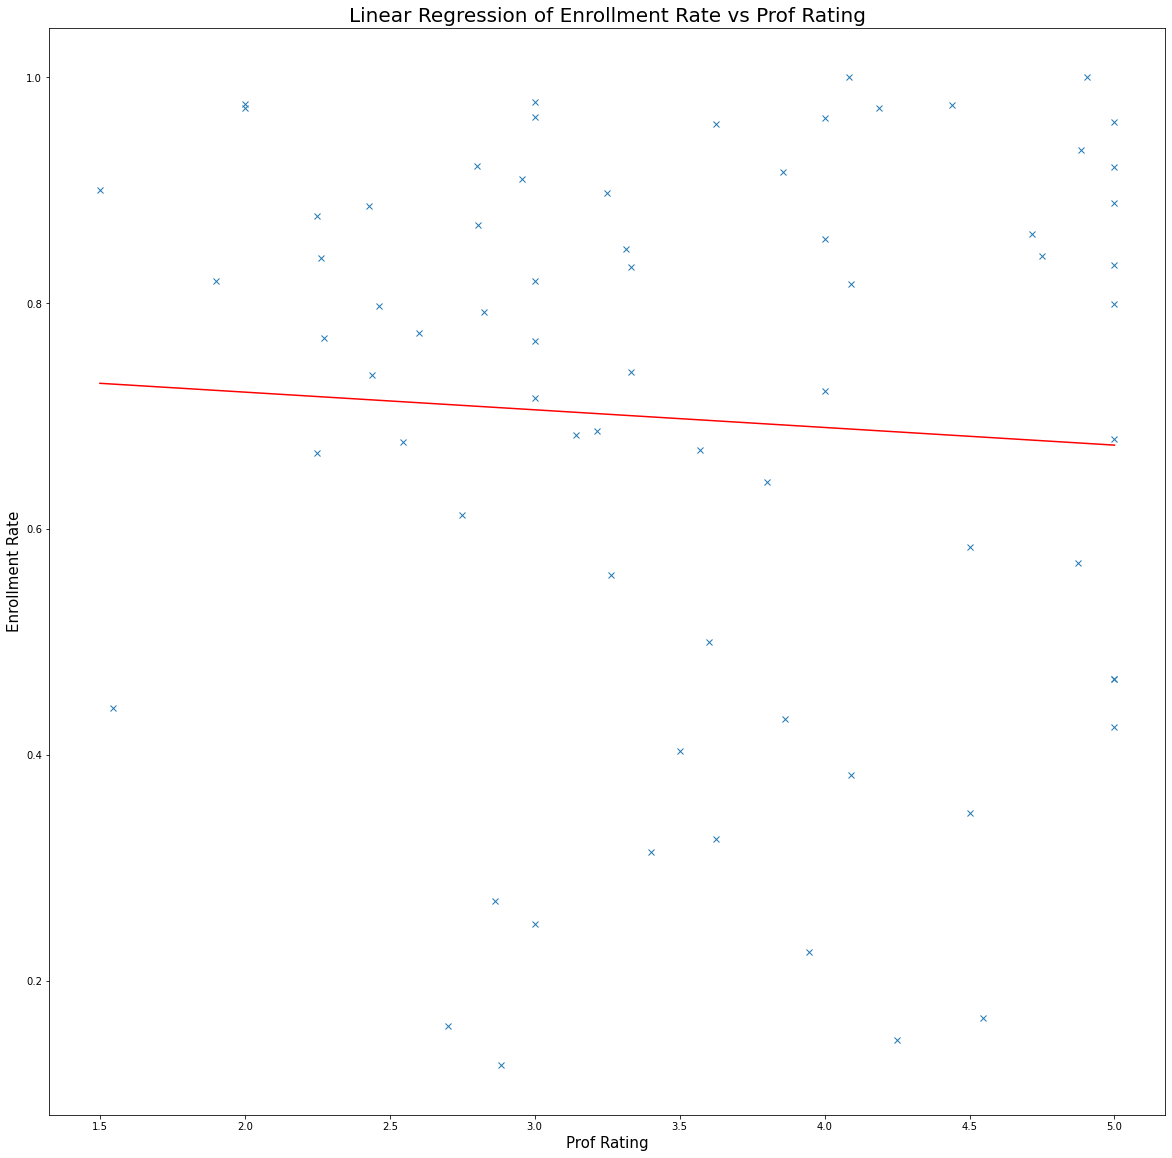

In [242]:
# Enrollment vs Prof Rating

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,1], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_prof_rating", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_prof_rating'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(20,20))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Prof Rating', fontsize = 20)
plt.xlabel("Prof Rating", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

### Linear Regression: Professor Overall Enrollment  vs Professor GPA

Linear Regression: y = [0.07407593]x + [0.45661484]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7911
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.377
Time:                        19:19:59   Log-Likelihood:                -1.3985
No. Observations:                  71   AIC:                             6.797
Df Residuals:                      69   BIC:                             11.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

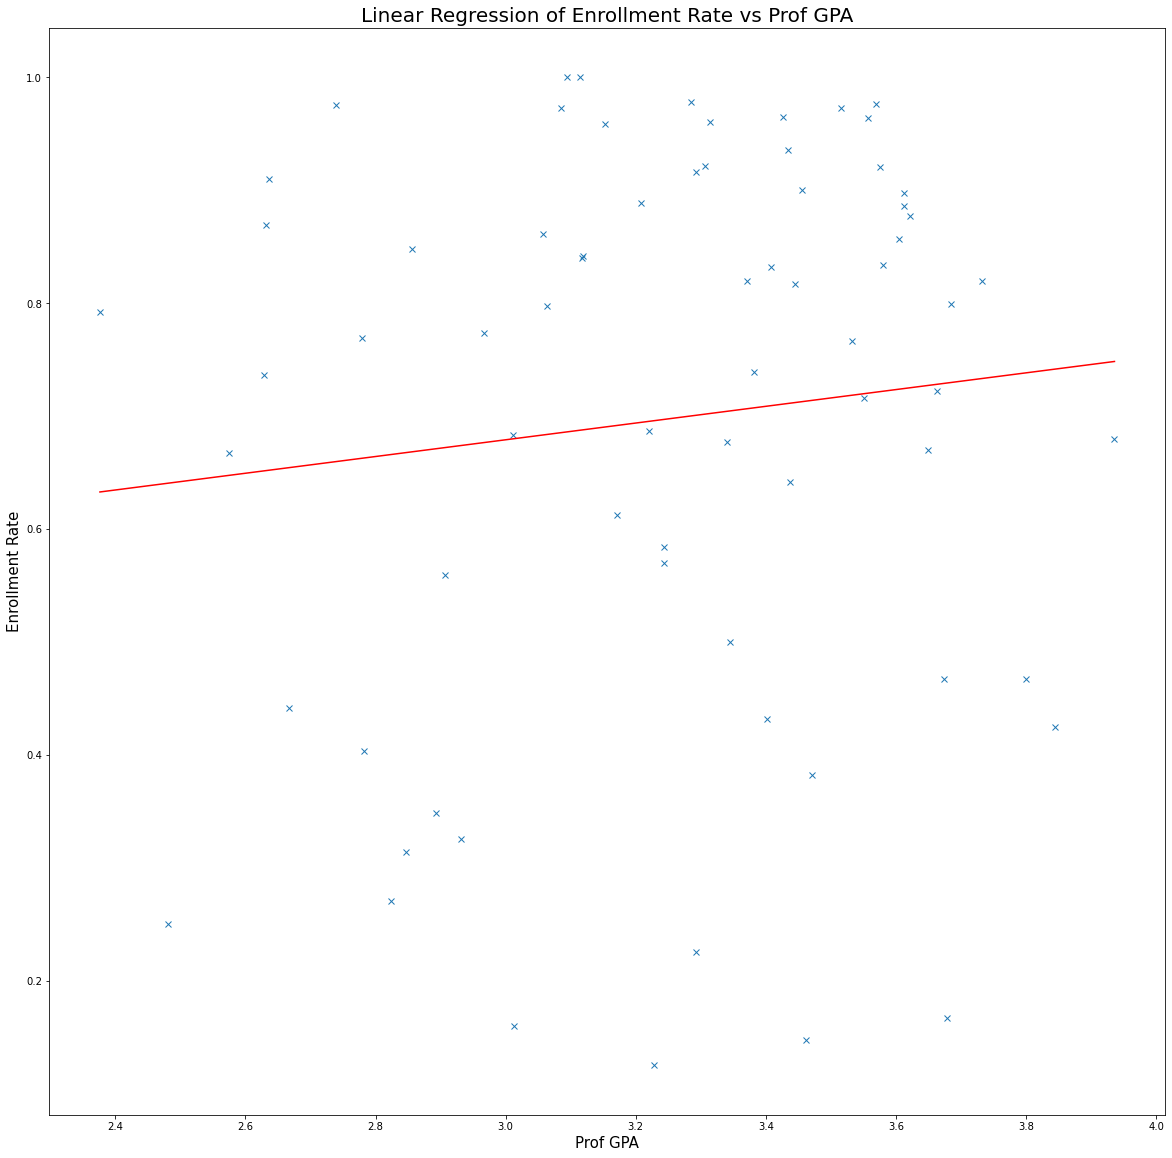

In [243]:
# Enrollment vs Prof GPA

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,2], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_prof_gpa", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_prof_gpa'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(20,20))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Prof GPA', fontsize = 20)
plt.xlabel("Prof GPA", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

Linear Regression: y = [-0.0221303]x + [0.76252252]
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.05871
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.809
Time:                        19:21:01   Log-Likelihood:                -1.7730
No. Observations:                  71   AIC:                             7.546
Df Residuals:                      69   BIC:                             12.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

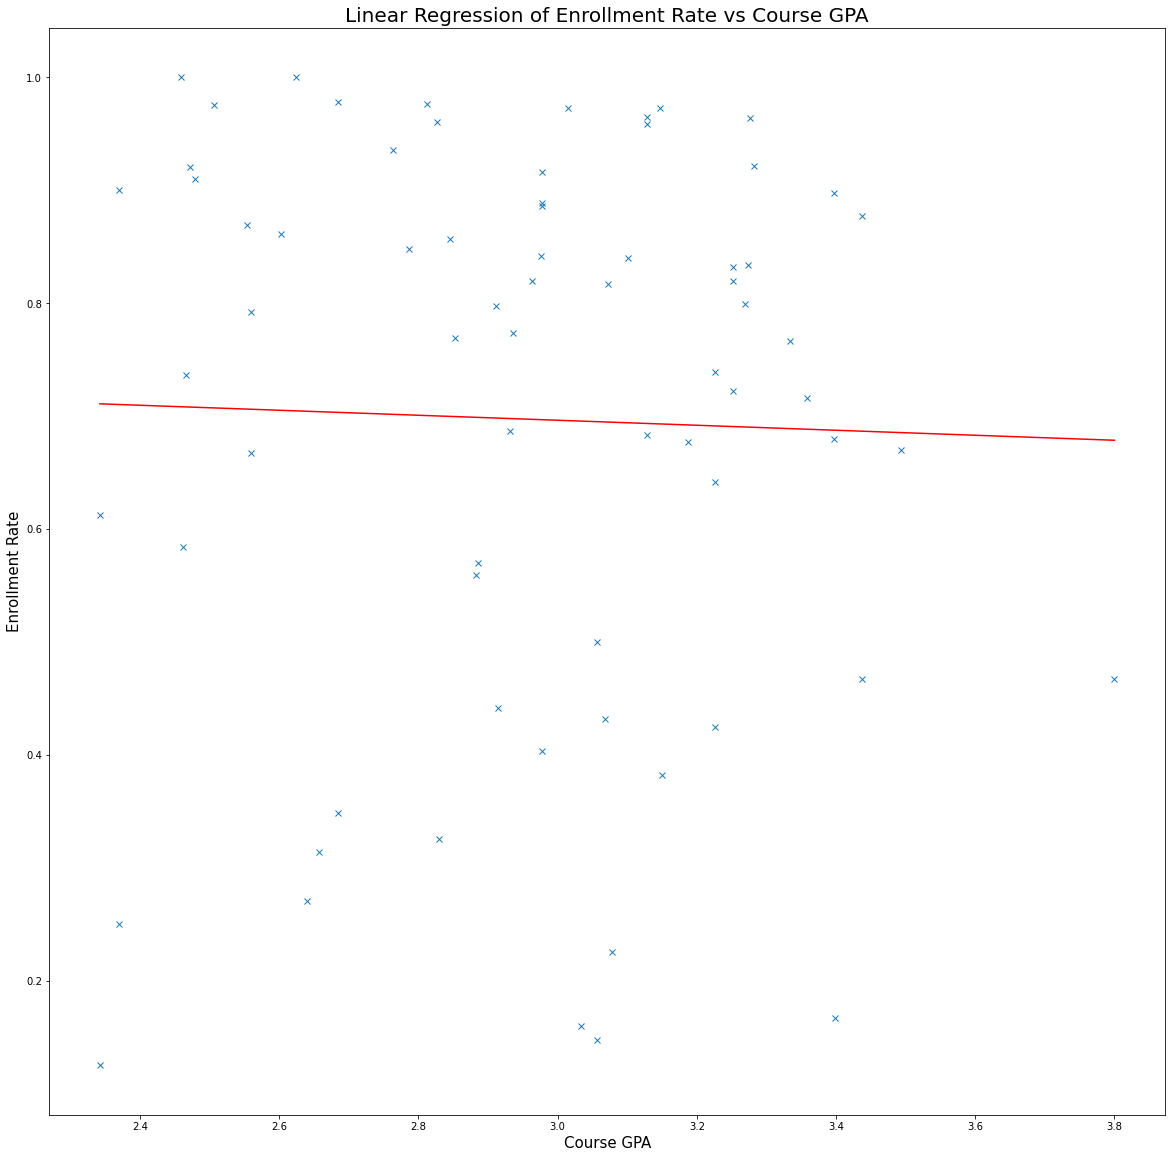

In [245]:
# Enrollment vs Course GPA

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

npMatrix = np.matrix(dummyProf)
X, Y = npMatrix[:,3], npMatrix[:,4]
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
b = model.intercept_

print ("Linear Regression: y = {0}x + {1}".format(slope_course_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_course_gpa", data=dummyProf).fit()
print(result.summary())

x_data = dummyProf['avg_course_gpa'].values
y_data = dummyProf ['overall_enrollRate'].values

x1 = np.linspace(x_data.min(), x_data.max(), 100)
y1 = x1*slope_course_gpa+b
plt.figure(figsize=(20,20))
plt.plot(x_data, y_data,'x',x1,y1,'r')
plt.title('Linear Regression of Enrollment Rate vs Course GPA', fontsize = 20)
plt.xlabel("Course GPA", fontsize=15)
plt.ylabel("Enrollment Rate", fontsize=15)
plt.show()

### Linear Regression: 3 Variables and interactions

In [246]:
X = dummyProf[['avg_course_gpa', 'avg_prof_rating', 'avg_prof_gpa']]
Y = dummyProf['overall_enrollRate']
model = LinearRegression().fit(X,Y)
slope_course_gpa = model.coef_[0]
slope_avg_prof_rating = model.coef_[1]
slope_avg_prof_gpa = model.coef_[2]
b = model.intercept_
print ("Linear Regression: y = {0}x1 + {1}x2 + {2}x3 + {3}".format(slope_course_gpa, slope_avg_prof_rating, slope_avg_prof_gpa, b))
result = sm.ols(formula="overall_enrollRate ~ avg_course_gpa*avg_prof_rating*avg_prof_gpa", data=dummyProf).fit()
print(result.summary())

Linear Regression: y = -0.14704193562898163x1 + -0.03324784713935086x2 + 0.19804640855431882x3 + 0.6058969085422372
                            OLS Regression Results                            
Dep. Variable:     overall_enrollRate   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.294
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.268
Time:                        19:21:40   Log-Likelihood:                 2.9651
No. Observations:                  71   AIC:                             10.07
Df Residuals:                      63   BIC:                             28.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [

### Analysis
According to our linear regression models, the slopes are not steep, and in fact, they are negative not positive. The p-values are high, which means we should accept the null hypothesis. For the linear regression models with course gpa, average professor ratings, and average professor gpas are respectively 0.984, 0.460, and 0.460, which are pretty high. Also, because these varaibles are dependent on each other and they all have different slopes we decided there is an interaction term. As a result, we ran a multi-variable linear regression

In [ ]:
classifDf = masterDf.groupby("instructor_name").mean().reset_index(0)
classifDf = classifDf[["instructor_name", "avg_prof_rating", "avg_enroll_rate_prof_per_class"]]

def profCategory(rating):
    if rating >= 4:
        return "Excellent"
    elif rating >= 3:
        return "Good"
    elif rating >= 2:
        return "Average"
    else:
        return "Bad"

prof_type = list(map(profCategory, classifDf.avg_prof_rating))
classifDf["prof_category"] = prof_type
classifDf

,instructor_name,avg_prof_rating,avg_enroll_rate_prof_per_class,prof_category
0,A.U. Shankar,2.4400,0.639029,Average
1,Abhinav Bhatele,4.0000,0.500000,Excellent
2,Adam Porter,2.5455,0.867200,Average
3,Amol Deshpande,3.0000,0.975610,Good
4,Andrew Childs,4.7143,0.766726,Excellent
...,...,...,...,...
66,Thomas Goldstein,5.0000,0.458649,Excellent
67,Vibha Sazawal,3.2500,1.000000,Good
68,William Gasarch,4.1875,0.755828,Excellent
69,William Regli,2.0000,0.973684,Average


71


<AxesSubplot:>

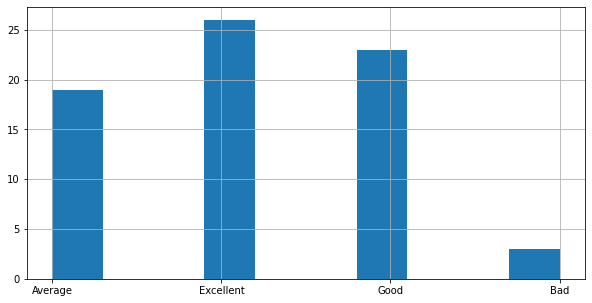

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

print(len(classifDf))
classifDf.prof_category.hist()

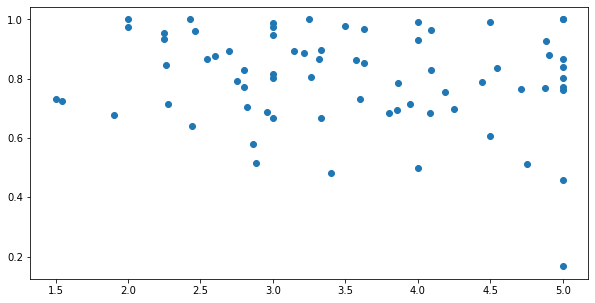

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
ax.scatter( classifDf.avg_prof_rating, classifDf.avg_enroll_rate_prof_per_class)

In [ ]:
fig, ax = plt.subplots()

### Collecting residuals per continent
residuals_per_continent = []
continents = sorted(list(set(data["continent"].values)))


for continent in continents:
    residuals_per_continent.append(list(data[data.continent == continent]["residuals"].values))

### Plot data collected above in boxplots
parts = ax.boxplot(residuals_per_continent,continents, labels= continents,showmeans=True)

### Labeling figure
ax.set_xlabel("Continents")
ax.set_ylabel("Residuals")

In [ ]:
classifDf.loc[classifDf.avg_prof_rating == 5]

,instructor_name,avg_prof_rating,avg_enroll_rate_prof_per_class,prof_category
20,Elias Gonzalez,5.0,1.000000,Excellent
24,Garrett Vanhoy,5.0,0.840630,Excellent
34,Jennifer Manly,5.0,0.773077,Excellent
38,Jordan Boyd-Graber,5.0,0.867347,Excellent
44,Matthias Zwicker,5.0,0.802553,Excellent
50,Mihai Pop,5.0,0.760714,Excellent
53,Mollye Bendell,5.0,0.166667,Excellent
64,Scott Gilkeson,5.0,1.000000,Excellent
66,Thomas Goldstein,5.0,0.458649,Excellent


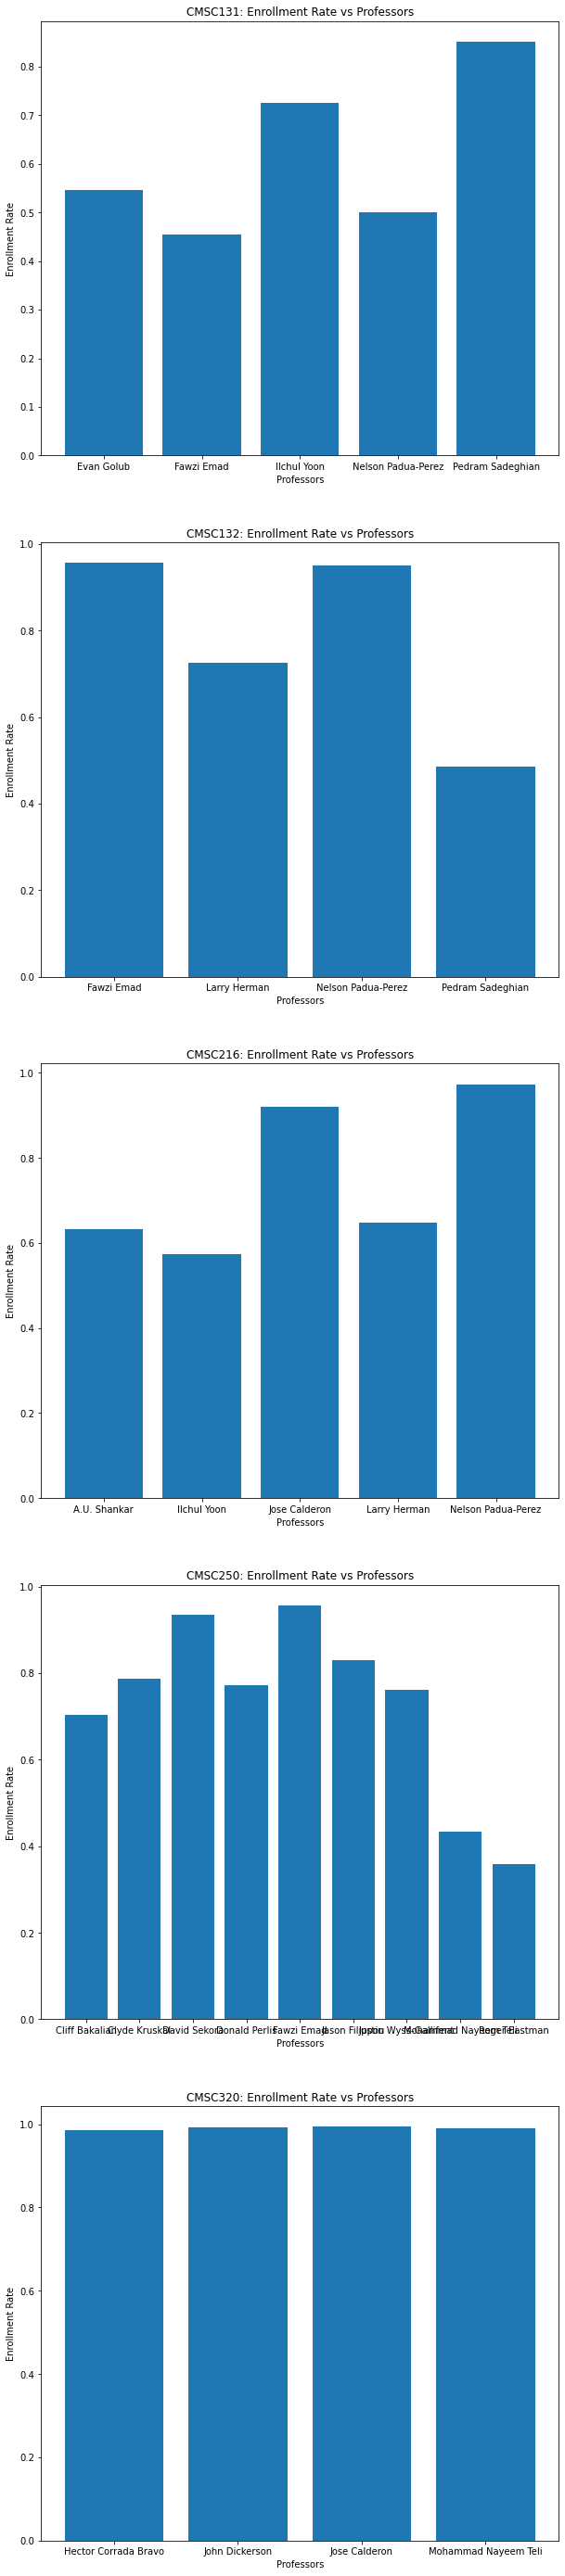

In [248]:
fig, ax = plt.subplots(5, 1)
fig.set_figheight(50)
fig.set_figwidth(10)

courseIDs = list(masterDf.course_id.unique())
courseTotalSeats = masterDf.groupby("course_id").sum()["total_seats"]
maxCapacityCourse = courseTotalSeats.sort_values(ascending=False)[0:10].index
maxCapacityCourse = list(maxCapacityCourse)
maxCapacityCourse = sorted(maxCapacityCourse)

# i = 0
for i in range(5):
    course = maxCapacityCourse[i]
    data = masterDf.loc[masterDf.course_id == course]
    ax[i].bar(data.instructor_name, data.avg_enroll_rate_prof_per_class)
    ax[i].set_xlabel("Professors")
    ax[i].set_ylabel("Enrollment Rate")
    ax[i].set_title(f"{course}: Enrollment Rate vs Professors")

In [ ]:
maxCapacityCourse

['CMSC131',
 'CMSC132',
 'CMSC216',
 'CMSC250',
 'CMSC320',
 'CMSC330',
 'CMSC351',
 'CMSC414',
 'CMSC420',
 'CMSC433']

In [ ]:
required = [
    'CMSC131',
    'CMSC132',
    'CMSC216',
    'CMSC250',
    'CMSC320',
    'CMSC330',
    'CMSC351'
]

isRequiredIndex = []
for course in required:
    isRequiredIndex += list(masterDf.loc[ masterDf.course_id == course ].index)

nonRequiredDf = masterDf.drop(isRequiredIndex)
nonRequiredDf

,course_id,instructor_last_name,instructor_name,avg_course_gpa,avg_prof_rating,avg_prof_gpa,avg_enroll_rate_prof_per_class,total_seats
1,CMSC412,Shankar,A.U. Shankar,2.48961,2.4400,2.756992,0.646667,150
2,CMSC416,Bhatele,Abhinav Bhatele,3.02750,4.0000,3.460000,0.933333,135
3,CMSC498X,Bhatele,Abhinav Bhatele,3.52466,4.0000,3.652632,0.066667,30
4,CMSC436,Porter,Adam Porter,3.18747,2.5455,3.339746,0.867200,625
5,CMSC424,Deshpande,Amol Deshpande,2.68394,3.0000,3.285546,0.975610,615
...,...,...,...,...,...,...,...,...
144,CMSC434,Sazawal,Vibha Sazawal,3.39691,3.2500,3.613027,1.000000,87
145,CMSC250H,Gasarch,William Gasarch,3.41868,4.1875,3.685522,0.762887,97
146,CMSC452,Gasarch,William Gasarch,2.87481,4.1875,3.346574,0.748768,203
147,CMSC421,Regli,William Regli,3.01543,2.0000,3.084559,0.973684,228


In [ ]:
nr_classifDf = nonRequiredDf.groupby("instructor_name").mean().reset_index(0)
nr_classifDf = nr_classifDf[["instructor_name", "avg_prof_rating", "avg_enroll_rate_prof_per_class"]]

def profCategory(rating):
    if rating >= 4:
        return "Excellent"
    elif rating >= 3:
        return "Good"
    elif rating >= 2:
        return "Average"
    else:
        return "Bad"

prof_type = list(map(profCategory, nr_classifDf.avg_prof_rating))
nr_classifDf["prof_category"] = prof_type
nr_classifDf

,instructor_name,avg_prof_rating,avg_enroll_rate_prof_per_class,prof_category
0,A.U. Shankar,2.4400,0.646667,Average
1,Abhinav Bhatele,4.0000,0.500000,Excellent
2,Adam Porter,2.5455,0.867200,Average
3,Amol Deshpande,3.0000,0.975610,Good
4,Andrew Childs,4.7143,0.766726,Excellent
...,...,...,...,...
60,Thomas Goldstein,5.0000,0.458649,Excellent
61,Vibha Sazawal,3.2500,1.000000,Good
62,William Gasarch,4.1875,0.755828,Excellent
63,William Regli,2.0000,0.973684,Average


65


<AxesSubplot:>

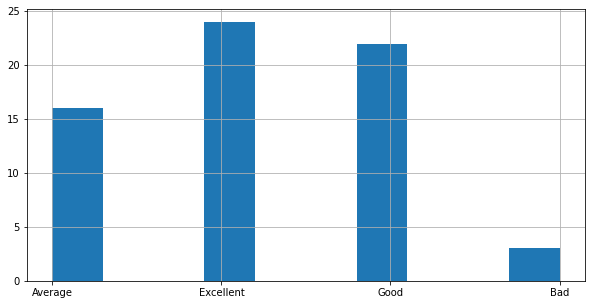

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

print(len(nr_classifDf))
nr_classifDf.prof_category.hist()